<a href="https://colab.research.google.com/github/GlMo995/EVRP_GA/blob/master/VRP_Objdects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs
import random as rand
from scipy.spatial import distance
import copy

np.random.seed(3)

In [2]:
import sys
!{sys.executable} -m pip install deap
import deap
from deap import base, creator, tools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 951.4 kB/s eta 0:00:00


In [3]:
class Customer_CS_Node:
    def __init__(self, num_cities, num_CS, center_box, start_time, end_time, Capacity_CS):
        self.num_cities = num_cities
        self.num_CS = num_CS
        self.center_box = center_box
        self.start_time = start_time
        self.end_time = end_time
        self.Capacity_CS = Capacity_CS
        self.num_clients = self.num_cities - 1

        #city coordinates
        self.cities_coord, _ = make_blobs(n_samples=self.num_cities,
                                          centers=20,
                                          cluster_std=150,
                                          center_box=self.center_box,
                                          random_state=100)

        #charging station coordinates
        self.charging_coord, _ = make_blobs(n_samples=self.num_CS,
                                            centers=20,
                                            cluster_std=180,
                                            center_box=self.center_box,
                                            random_state=150)

        self.all_names = [i for i in range(self.num_cities)]
        self.all_names_ = [i + self.num_cities for i in range(self.num_CS)]
        self.client_names = [i for i in range(1, self.num_cities)]
        self.charging_names = [i for i in range(self.num_cities, self.num_cities + self.num_CS)]

        self.all_coord_dict = {name: coord for name, coord in zip(self.all_names, self.cities_coord)}
        self.client_coord_dict = {name: coord for name, coord in zip(self.client_names, self.cities_coord[1:])}
        self.charging_coord_dict = {name: coord for name, coord in zip(self.charging_names, self.charging_coord)}

        self.client_time_windows = [(0, 0)]
        #client time windows for each customer and add to the list
        for client in self.client_coord_dict:
            window_width = np.random.uniform(50, 100)
            start_time_window = np.random.uniform(self.start_time, self.end_time - window_width)
            end_time_window = start_time_window + window_width
            self.client_time_windows.append((round(start_time_window, 2), min(round(end_time_window, 2), end_time)))

    def calculate_distances(self):
        dist_matrix = distance.cdist(self.cities_coord, self.cities_coord, 'euclidean')
        dist_chargestation = distance.cdist(self.cities_coord, self.charging_coord, 'euclidean')
        return dist_matrix, dist_chargestation

In [4]:
class Vehicle:
    def __init__(self, num_vehicles, vehicle_payload, DeltaT, charging_time, Charging_duration):
        self.num_vehicles = num_vehicles
        self.vehicle_payload = vehicle_payload
        self.t_sample = DeltaT
        self.charging_time = charging_time
        self.Charging_duration = Charging_duration
        self.m_air = 1.32  # Air density in kg/m3
        self.C_w = 0.109  # Air drag coefficient
        self.mu_rr = 0.03  # Rolling resistance coefficient
        self.A = 1.2  # Frontal area in square meters
        self.g = 9.8  # Acceleration due to gravity
        self.mass = 20  # kg
        self.alpha = 0
        self.capacity = 4 * 3600  # Battery capacity in Ampere-second

    def calculate_time(self, distance, acceleration, initial_velocity):
        time = (-initial_velocity + math.sqrt(initial_velocity**2 + 2 * acceleration * distance)) / acceleration
        return time

    def calculate_velocity(self, initial_velocity, acceleration, distance):
        velocity = math.sqrt(initial_velocity**2 + 2 * acceleration * distance)
        return velocity

    def calculate_acceleration(self, initial_velocity, time, distance):
        acceleration = (2 * distance) / time ** 2 - (2 * initial_velocity) / time
        return acceleration

    def calculate_displacement(self, time, initial_velocity, acceleration):
        displacement = initial_velocity * time + 0.5 * acceleration * time**2
        return displacement

    def calculate_power_mechanical(self, velocity, acceleration):
        power_mech = (
            0.5 * self.m_air * self.C_w * self.A * velocity**3 +
            self.mass * self.g * velocity * math.sin(self.alpha) +
            self.mass * self.g * self.mu_rr * velocity * math.cos(self.alpha) +
            self.mass * acceleration * velocity
        )
        return power_mech

    def update_soc(self, soc_old, power):
        current = self.calculate_current(soc_old, power)
        soc_change = (current * self.t_sample) / self.capacity
        return soc_change

    def calculate_current(self, soc, power_mechanical):
        voltage = self.soc_to_voltage(soc)
        current = power_mechanical / voltage
        return current

    def soc_to_voltage(self, soc):
        voltage = (3.32 * math.exp(0.217 * soc)) - (0.784 * math.exp(-16.74 * soc))
        return voltage

In [5]:
class GeneticAlgorithm:
    def __init__(self, soc_set, num_vehicles, vehicle_payload, DeltaT, num_cities, num_CS, center_box, start_time, end_time, V_max, a_max, charging_time, Capacity_CS, Charging_duration,
                 CostBattery, CostEng, CostTime, num_population, num_generations, prob_crossover, prob_mutation):
        self.soc_set = soc_set
        self.num_vehicles = num_vehicles
        self.vehicle_payload = vehicle_payload
        self.V_max = V_max
        self.a_max = a_max
        self.start_time = start_time
        self.end_time = end_time
        self.DeltaT = DeltaT
        self.C_batt = CostBattery
        self.C_eng = CostEng
        self.C_time = CostTime
        self.num_population = num_population
        self.num_generations = num_generations
        self.prob_crossover = prob_crossover
        self.prob_mutation = prob_mutation

        self.Customer_CS_Node = Customer_CS_Node(num_cities, num_CS, center_box, start_time, end_time, Capacity_CS)
        self.vehicle = Vehicle(num_vehicles, vehicle_payload, DeltaT, charging_time, Charging_duration)

        self.records = []
        self.time_trace = []

        self.tb = base.Toolbox()

        #best_list,  best = self.run_genetic_algorithm()


    def get_route(self, _chromo):
        route_set = [([],_chromo[3][i],_chromo[4][i],_chromo[5][i]) for i in range(self.num_vehicles)]
        for s, v, c in zip(_chromo[0], _chromo[1], _chromo[2]):
            route_set[v][0].append((s, c))
        return route_set


    def chromo_create(self):
        CS = []

        schedule = copy.deepcopy(self.Customer_CS_Node.client_names)
        vehicle = list(np.random.randint(self.num_vehicles, size=len(schedule)))

        velocities = rand.sample(self.V_max, self.num_vehicles)
        acc = rand.sample(self.a_max, self.num_vehicles)

        start_times = []
        for _ in range(self.num_vehicles):
            start_time_ = rand.randint(self.start_time, self.end_time)
            start_times.append(start_time_)

        rand.shuffle(schedule)
        for i in range(len(schedule)):
            CS.append(rand.choice(self.Customer_CS_Node.charging_names + [-1]))
        chromo = [schedule, vehicle, CS, start_times, velocities, acc]

        return chromo



    def chromo_eval(self, _chromo):
        _dist_matrix , dist_chargestation = self.Customer_CS_Node.calculate_distances()

        soc_cost = 0
        energy_cost = 0
        Time_cost = 0
        changesoc = 0

        self.soc_values = []
        self.power_values = []
        self.velocity_values = []
        self.accelaration_value = []
        self.time_values = []
        self.displacement_values = []
        self.energy_values = []
        self.charging_station_usage = {}
        self.soc_change = []
        self.records = []
        self.time_trace = []

        trace_cs = {}

        #finding route coresponding to each vehicle
        route_set = [[] for _ in range(self.num_vehicles)]
        for s, v, c in zip(_chromo[0], _chromo[1], _chromo[2]):
            route_set[v].append((s, c))

        #finding the number of charging for each vehicle ---> penalize if more than charging_time variable
        charging_count_per_vehicle = [sum(1 for _, c in vehicle_route if c != -1) for vehicle_route in route_set]
        soc_cost += sum([count - self.vehicle.charging_time for count in charging_count_per_vehicle if count > self.vehicle.charging_time]) * 0.5

        for i, route in enumerate(route_set):
            self.arrival_times = {}
            self.destination_data = []

            arrival_time =  _chromo[3][i]
            v_max = _chromo[4][i]
            acceleration = _chromo[5][i]
            counter_undervalue = 0
            previous_velocity = 0

            energy_total = 0
            arrived_time = 0
            soc = self.soc_set[i]

            self.vehicle_soc_values = [soc]
            self.vehicle_power_values = [0]
            self.vehicle_velocity_values = [0]
            self.vehicle_accelaration_values = []
            self.vehicle_displacement = []
            next_itr_charging =  False
            vehicle_travel_time = 0

            flat_route = [item for city in route for item in city]
            flat_route.append(0)

            for p in range(0, len(flat_route)):
                Current_Window = None
                if p == 0:
                    _i = 0  # Depot
                    _j = flat_route[0]
                    des = _j
                    distance = _dist_matrix[_i][_j]
                    Current_Window = self.Customer_CS_Node.client_time_windows[_j]
                    #angel = calculate_angle(all_coord_dict[_i], all_coord_dict[_j])

                elif p == len(flat_route) -1 and flat_route[p - 1] == -1:
                    break

                elif p == len(flat_route) -1:
                    _j = flat_route[p -1]
                    if _j != -1:
                      _i = 0  # Depot
                      distance = dist_chargestation[_i][_j - self.Customer_CS_Node.num_cities]
                      #angel = calculate_angle(all_coord_dict_[_j], all_coord_dict[_i])

                elif p == len(flat_route) - 2 and flat_route[p] == -1:
                    _j = 0
                    des = _j
                    _i = flat_route[p - 1]
                    distance = _dist_matrix[_i][_j]
                    #angel = calculate_angle(all_coord_dict[_j], all_coord_dict[_i])

                elif flat_route[p] == -1:
                        _i = flat_route[p - 1]
                        _j = flat_route[p + 1]
                        des = _j
                        distance = _dist_matrix[_i][_j]
                        Current_Window = self.Customer_CS_Node.client_time_windows[_j]
                        #angel = calculate_angle(all_coord_dict[_i], all_coord_dict[_j])
                else:
                    if p % 2 == 0:
                        if flat_route[p - 1] == -1:
                            continue
                        else:
                            _i = flat_route[p]
                            _j = flat_route[p - 1]
                            des = _i
                            #angel = calculate_angle(all_coord_dict_[_j], all_coord_dict[_i])
                            _j = _j - self.Customer_CS_Node.num_cities
                            Current_Window = self.Customer_CS_Node.client_time_windows[_i]
                            distance = dist_chargestation[_i][_j]

                    else:
                        _i = flat_route[p - 1]
                        _j = flat_route[p]
                        des = _i
                        CS = _j
                        #angel = calculate_angle(all_coord_dict[_i], all_coord_dict_[_j])
                        _j = _j - self.Customer_CS_Node.num_cities
                        distance = dist_chargestation[_i][_j]
                        next_itr_charging = True

                acceleration = _chromo[5][i]
                self.vehicle_accelaration_values.append(acceleration)

                total_dis = 0
                traverse_distance = 0

                while traverse_distance < distance:
                      time_seconds  = self.DeltaT
                      vehicle_travel_time += time_seconds


                      displacement = self.vehicle.calculate_displacement(time_seconds, previous_velocity, acceleration)
                      traverse_distance += displacement
                      total_dis += displacement

                      # if vehicle reach the customer
                      if traverse_distance >= distance and next_itr_charging == False:
                          arrival_time +=  vehicle_travel_time
                          self.arrival_times[des] = arrival_time

                          if Current_Window != None:
                              if arrival_time > Current_Window[1]:
                                    Time_cost +=  3.5 *(arrival_time - Current_Window[1])
                              if arrival_time < Current_Window[0]:
                                    Time_cost +=  3.5 *(Current_Window[0] - arrival_time)

                          previous_velocity = 0
                          acceleration = 0
                          power_mech = self.vehicle.calculate_power_mechanical(previous_velocity, acceleration)

                          self.vehicle_accelaration_values.append(acceleration)
                          self.vehicle_velocity_values.append(previous_velocity)
                          self.vehicle_power_values.append(power_mech)
                          self.vehicle_soc_values.append(soc)

                          data = {'soc': soc, 'acceleration': acceleration, 'velocity': previous_velocity , 'Time': vehicle_travel_time, 'power': power_mech}
                          self.destination_data.append(data)

                      #if the stop point is CS
                      elif traverse_distance >= distance and next_itr_charging == True:
                          time = 0
                          start_t = _chromo[3][i] + vehicle_travel_time
                          end_t = _chromo[3][i] + (vehicle_travel_time + self.vehicle.Charging_duration)
                          # Update trace_cs tracking for the specific CS
                          if CS not in trace_cs:
                              trace_cs[CS] = {}
                              trace_cs[CS][i] = [(start_t, end_t)]
                          else:
                              if i not in trace_cs[CS]:
                                  for v_id, visit_times in trace_cs[CS].items():
                                        for visit in visit_times:
                                            if  visit[0] < end_t and start_t < visit[1]:
                                                time += 1
                                  if time > self.Customer_CS_Node.Capacity_CS:
                                        soc_cost += 1.5 * (time - self.Customer_CS_Node.Capacity_CS)

                                  trace_cs[CS][i] = [(start_t, end_t)]
                              else:
                                  for v_id, visit_times in trace_cs[CS].items():
                                        for visit in visit_times:
                                            if  visit[0] < end_t and start_t < visit[1]:
                                                time += 1
                                  if time > self.Customer_CS_Node.Capacity_CS:
                                        soc_cost += 1.5 * (time - self.Customer_CS_Node.Capacity_CS)
                                  trace_cs[CS][i].append((start_t, end_t))

                          vehicle_travel_time += self.vehicle.Charging_duration
                          soc_cost += 1.7 * (0.98 - soc)
                          soc = 0.98
                          self.vehicle_soc_values.append(soc)
                          next_itr_charging =  False

                          arrival_time +=  vehicle_travel_time
                          self.arrival_times[des] = arrival_time

                          data = {'soc': soc, 'acceleration': acceleration, 'velocity': previous_velocity , 'Time': vehicle_travel_time, 'power': power_mech}
                          self.destination_data.append(data)

                      else:
                          #calculate velocity at the end of the displacement
                          previous_velocity = self.vehicle.calculate_velocity(previous_velocity, acceleration, displacement)
                          #if the calculated velocity is more than max speed of vehicle
                          if previous_velocity >= v_max:
                              previous_velocity = v_max
                              acceleration = 0

                          self.vehicle_displacement.append(total_dis)
                          self.vehicle_accelaration_values.append(acceleration)
                          self.vehicle_velocity_values.append(previous_velocity)

                          #calculate power
                          power_mech = self.vehicle.calculate_power_mechanical(previous_velocity, acceleration)
                          self.vehicle_power_values.append(power_mech)

                          #calculate energy
                          energy_total += power_mech * time_seconds

                          soc_new = self.vehicle.update_soc(soc, power_mech)
                          soc = soc - soc_new
                          self.vehicle_soc_values.append(soc)

                          if soc <= 0:
                              soc_cost +=  np.Inf
                              break

                          if soc <= 0.25:
                              counter_undervalue +=1
                              soc_cost += 5.5 * counter_undervalue

                          data = {'soc': soc, 'acceleration': acceleration, 'velocity': previous_velocity , 'Time': vehicle_travel_time, 'power': power_mech}
                          self.destination_data.append(data)


            self.time_values.append(vehicle_travel_time)
            self.soc_values.append(self.vehicle_soc_values)
            self.energy_values.append(energy_total)
            self.time_trace.append(self.arrival_times)
            self.power_values.append(self.vehicle_power_values)
            self.velocity_values.append(self.vehicle_velocity_values)
            self.accelaration_value.append(self.vehicle_accelaration_values)
            self.records.append(self.destination_data)


        for v_soc in self.soc_values:
            if len(v_soc)== 1:
                soc_cost += 5* sum([v_soc[-1] - v_soc_other[-1]  for v_soc_other in self.soc_values])

            difference = v_soc[0] - v_soc[-1]
            self.soc_change.append(difference)

        soc_cost += sum(self.soc_change)
        energy_cost = sum(self.energy_values)
        #Time_cost += sum(self.time_values)

        soc = self.C_batt * soc_cost
        energy = self.C_eng * energy_cost
        time = self.C_time * Time_cost

        print('t', time)
        print('s', soc)
        print('e', energy)

        return soc, energy_cost, time



    def crossover(self, chromo1, chromo2):
        def partial_crossover(chromo1, chromo2, cuts):
            size = len(chromo1)
            p1, p2 = [0] * size, [0] * size

            for i in range(size):
                p1[chromo1[i] - 1] = i
                p2[chromo2[i] - 1] = i

            for i in range(cuts[0], cuts[1]):
                temp1 = chromo1[i] - 1
                temp2 = chromo2[i] - 1

                chromo1[i], chromo1[p1[temp2]] = temp2 + 1, temp1 + 1
                chromo2[i], chromo2[p2[temp1]] = temp1 + 1, temp2 + 1

                p1[temp1], p1[temp2] = p1[temp2], p1[temp1]
                p2[temp1], p2[temp2] = p2[temp2], p2[temp1]

        def partial_crossover_CS(chromo1, chromo2, cuts):
            size = len(chromo1)
            p1, p2 = [0] * 2 * size, [0] * 2 * size

            for i in range(size):
                p1[chromo1[i] - 1] = i
                p2[chromo2[i] - 1] = i

            for i in range(cuts[0], cuts[1]):
                temp1 = chromo1[i] - 1
                temp2 = chromo2[i] - 1

                chromo1[i], chromo1[p1[temp2]] = temp2 + 1, temp1 + 1
                chromo2[i], chromo2[p2[temp1]] = temp1 + 1, temp2 + 1

                p1[temp1], p1[temp2] = p1[temp2], p1[temp1]
                p2[temp1], p2[temp2] = p2[temp2], p2[temp1]


        def get_chromo_cut(cut_range=None, mutation=False):
            if mutation:
                randrange = self.Customer_CS_Node.num_clients
            else:
                randrange = self.Customer_CS_Node.num_clients + 1

            if cut_range is None:
                cut1 = rand.randrange(randrange)
                cut2 = rand.randrange(randrange)
                if cut1 > cut2:
                    tmp = cut2
                    cut2 = cut1
                    cut1 = tmp
                cut_range = cut2 - cut1
            else:

                cut1 = rand.randrange(self.Customer_CS_Node.num_clients + 1 - cut_range)
                cut2 = cut1 + cut_range
            return cut1, cut2, cut_range


        def get_chromo_cut_vehicles():
            if self.num_vehicles == 2:
                cut1, cut2 = 0, 1
                return cut1, cut2

            randrange = self.num_vehicles - 1
            cut1 = rand.randrange(randrange)
            cut2 = rand.randrange(randrange)

            while cut1 == cut2:
                cut2 = rand.randrange(randrange)

            if cut1 > cut2:
                cut1, cut2 = cut2, cut1

            return cut1, cut2

        def swap_genes(chrom1, chrom2, cuts1, cuts2):
            tmp = chrom1[cuts1[0]:cuts1[1]]
            chrom1[cuts1[0]:cuts1[1]] = chrom2[cuts2[0]:cuts2[1]]
            chrom2[cuts2[0]:cuts2[1]] = tmp


        cuts = get_chromo_cut()
        partial_crossover(chromo1[0], chromo2[0], cuts)
        partial_crossover_CS(chromo1[2], chromo2[2], cuts)

        cuts1 = get_chromo_cut()
        cuts2 = get_chromo_cut(cuts1[2])

        cutst = get_chromo_cut_vehicles()
        cutstt = get_chromo_cut_vehicles()

        cutsv = get_chromo_cut_vehicles()
        cutsvv = get_chromo_cut_vehicles()

        cutsa = get_chromo_cut_vehicles()
        cutsaa = get_chromo_cut_vehicles()

        swap_genes(chromo1[1], chromo2[1], cuts1, cuts2)
        swap_genes(chromo1[3], chromo2[3], cutst, cutst)
        swap_genes(chromo1[4], chromo2[4], cutsv, cutsv)
        swap_genes(chromo1[5], chromo2[5], cutsa, cutsa)




    def mutation(self, chromo):
        def swap_gene(_chromo):
            cuts = get_chromo_cut(mutation=True)
            cuts_ = get_chromo_cut_vehicles()
            cuts_1 = get_chromo_cut_vehicles()

            if np.random.rand() < 0.5:
                tmp = _chromo[0][cuts[0]]
                _chromo[0][cuts[0]] = _chromo[0][cuts[1]]
                _chromo[0][cuts[1]] = tmp

                tmp_cs = _chromo[2][cuts[0]]
                _chromo[2][cuts[0]] = _chromo[2][cuts[1]]
                _chromo[2][cuts[1]] = tmp_cs

                tmp_t = _chromo[3][cuts_[0]]
                _chromo[3][cuts_[0]] = _chromo[3][cuts_[1]]
                _chromo[3][cuts_[1]] = tmp_t

                tmp_a = _chromo[5][cuts_1[0]]
                _chromo[5][cuts_1[0]] = _chromo[5][cuts_1[1]]
                _chromo[5][cuts_1[1]] = tmp_a
            else:
                tmp = _chromo[1][cuts[0]]
                _chromo[1][cuts[0]] = _chromo[1][cuts[1]]
                _chromo[1][cuts[1]] = tmp

                tmp_cs = _chromo[2][cuts[0]]
                _chromo[2][cuts[0]] = _chromo[2][cuts[1]]
                _chromo[2][cuts[1]] = tmp_cs

                tmp_v = _chromo[4][cuts_[0]]
                _chromo[4][cuts_[0]] = _chromo[4][cuts_[1]]
                _chromo[4][cuts_[1]] = tmp_v

        def shuffle_gene(_chromo):
            cuts = get_chromo_cut(mutation=True)
            cuts_ = get_chromo_cut_vehicles()
            cuts_1 = get_chromo_cut_vehicles()

            if np.random.rand() < 0.5:
                tmp = _chromo[0][cuts[0]:cuts[1]]
                np.random.shuffle(tmp)
                _chromo[0][cuts[0]:cuts[1]] = tmp

                tmp_cs = _chromo[2][cuts[0]:cuts[1]]
                np.random.shuffle(tmp_cs)
                _chromo[2][cuts[0]:cuts[1]] = tmp_cs

                tmp_v = _chromo[4][cuts_[0]:cuts_[1]]
                np.random.shuffle(tmp_v)
                _chromo[4][cuts_[0]:cuts_[1]] = tmp_v
            else:
                tmp = _chromo[1][cuts[0]:cuts[1]]
                np.random.shuffle(tmp)
                _chromo[1][cuts[0]:cuts[1]] = tmp

                tmp_cs = _chromo[2][cuts[0]:cuts[1]]
                np.random.shuffle(tmp_cs)
                _chromo[2][cuts[0]:cuts[1]] = tmp_cs

                tmp_t = _chromo[3][cuts_[0]:cuts_[1]]
                np.random.shuffle(tmp_t)
                _chromo[3][cuts_[0]:cuts_[1]] = tmp_t

                tmp_a = _chromo[5][cuts_1[0]:cuts_1[1]]
                np.random.shuffle(tmp_a)
                _chromo[5][cuts_1[0]:cuts_1[1]] = tmp_a

        def change_gene_CS(_chromo):
            index = rand.randint(0, len(_chromo[2])-1)
            _chromo[2][index] = rand.choice(self.Customer_CS_Node.charging_names + [-1])

            index_t = rand.randint(0, len(_chromo[3])-1)
            num = rand.randint(-60, 60)
            if self.start_time <= _chromo[3][index_t] + num <= self.end_time and _chromo[3][index_t] + num != 0:
                _chromo[3][index_t] = _chromo[3][index_t] + num
            else:
                _chromo[3][index_t] = rand.randint(7, 12)

            index_v = rand.randint(0, len(_chromo[4])-1)
            _chromo[4][index_v] = rand.choice(self.V_max)

            index_a = rand.randint(0, len(_chromo[5])-1)
            _chromo[5][index_a] = rand.choice(self.a_max)

        def get_chromo_cut(mutation=False):
            if mutation:
                randrange = self.Customer_CS_Node.num_clients
            else:
                randrange = self.Customer_CS_Node.num_clients + 1

            cut1 = rand.randrange(randrange)
            cut2 = rand.randrange(randrange)
            if cut1 > cut2:
                cut1, cut2 = cut2, cut1
            cut_range = cut2 - cut1

            return cut1, cut2, cut_range

        def get_chromo_cut_vehicles():
            if self.num_vehicles == 2:
                cut1, cut2 = 0, 1
                return cut1, cut2

            randrange = self.num_vehicles - 1
            cut1 = rand.randrange(randrange)
            cut2 = rand.randrange(randrange)

            while cut1 == cut2:
                cut2 = rand.randrange(randrange)

            if cut1 > cut2:
                cut1, cut2 = cut2, cut1

            return cut1, cut2


        if np.random.rand() < 0.5:
            swap_gene(chromo)
            change_gene_CS(chromo)
        else:
            shuffle_gene(chromo)
            change_gene_CS(chromo)



    def create_deap_functions(self):
        creator.create('Fitness_Func', base.Fitness, weights=(-1, -1, -1))
        creator.create('Individual', list, fitness=creator.Fitness_Func)

        self.tb.register('indexes', self.chromo_create)
        self.tb.register('individual', tools.initIterate, creator.Individual, self.tb.indexes)
        self.tb.register('population', tools.initRepeat, list, self.tb.individual)
        self.tb.register('evaluate', self.chromo_eval)
        self.tb.register('select', tools.selTournament)
        self.tb.register('mate', self.crossover)
        self.tb.register('mutate', self.mutation)



    def run_genetic_algorithm(self):
        self.create_deap_functions()

        population = self.tb.population(n=self.num_population)

        fitness_set = list(self.tb.map(self.tb.evaluate, population))
        for ind, fit in zip(population, fitness_set):
            ind.fitness.values = fit

        best_fit_list = []
        best_sol_list = []

        best_fit = float('inf')

        for gen in range(self.num_generations):
            if gen % 10 == 0:
                print(f'Generation: {gen:4} | Fitness: {best_fit:.2f}')

            offspring = self.tb.select(population, len(population), tournsize=3)
            offspring = list(map(self.tb.clone, offspring))

            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if np.random.random() < self.prob_crossover:
                    self.tb.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            for chromo in offspring:
                if np.random.random() < self.prob_mutation:
                    self.tb.mutate(chromo)
                    del chromo.fitness.values

            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitness_set = map(self.tb.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitness_set):
                ind.fitness.values = fit

            population[:] = offspring

            curr_best_sol = tools.selBest(population, 1)[0]
            curr_best_fit = curr_best_sol.fitness.values[0]

            if curr_best_fit < best_fit:
                best_sol = curr_best_sol
                best_fit = curr_best_fit

            best_fit_list.append(best_fit)
            best_sol_list.append(best_sol)

        return best_fit_list, best_sol

In [ ]:
class PlottingClass:
    def __init__(self, num_cities, num_CS, center_box,
                 start_time, end_time, Capacity_CS, GA , best_individual, best_fitness):

        self.GA = GA

        self.best_individual = best_individual
        self.best_fitness = best_fitness

        self.Customer_CS_Node = Customer_CS_Node(num_cities, num_CS, center_box, start_time, end_time, Capacity_CS)
        _, _, _ = self.GA.chromo_eval(best_individual)


    def plot_environment(self):
        plt.scatter(self.Customer_CS_Node.cities_coord[0, 0], self.Customer_CS_Node.cities_coord[0, 1], label='Depot', s=10,);
        plt.scatter(self.Customer_CS_Node.cities_coord[1:, 0], self.Customer_CS_Node.cities_coord[1:, 1], label='Customers', s=10)
        plt.scatter(self.Customer_CS_Node.charging_coord[:, 0], self.Customer_CS_Node.charging_coord[:, 1], label='Charging Stations', s=20, marker='s')
        plt.xlabel('X Coordinates')
        plt.ylabel('Y Coordinates')
        plt.legend()
        plt.show()


    def plot_cost(self):
        plt.plot(self.best_fitness)
        plt.show()


    def get_route(self):
        route_set = [([],self.best_individual[3][i],self.best_individual[4][i],self.best_individual[5][i]) for i in range(2)]
        for s, v, c in zip(self.best_individual[0], self.best_individual[1], self.best_individual[2]):
            route_set[v][0].append((s, c))
        return route_set

    def plot_routes(self):

        plot_size   = 20
        plot_width  = 16
        plot_height = 8

        params = {'legend.fontsize': 'large',
                  'figure.figsize': (plot_width,plot_height),
                  'axes.labelsize': plot_size,
                  'axes.titlesize': plot_size,
                  'xtick.labelsize': plot_size*0.75,
                  'ytick.labelsize': plot_size*0.75,
                  'axes.titlepad': 25}
        plt.rcParams.update(params)
        plt.rcParams.update(params)

        # Use the best_routes obtained from the GeneticAlgorithm class to plot the routes
        best_routes = self.get_route()

        plt.scatter(self.Customer_CS_Node.cities_coord[1:, 0], self.Customer_CS_Node.cities_coord[1:, 1], s=plot_size*2, cmap='viridis')
        plt.scatter(self.Customer_CS_Node.charging_coord[:, 0], self.Customer_CS_Node.charging_coord[:, 1], s=plot_size*4, cmap='viridis', marker='s')
        plt.scatter(self.Customer_CS_Node.cities_coord[0, 0], self.Customer_CS_Node.cities_coord[0, 1], s=plot_size*4, cmap='viridis')

        colors = ['red', 'blue', 'green', 'orange', 'purple']

        for i, txt in enumerate(self.Customer_CS_Node.all_names):
            plt.annotate(txt, (self.Customer_CS_Node.cities_coord[i, 0]+1, self.Customer_CS_Node.cities_coord[i, 1]+1))

        for i, txt in enumerate(self.Customer_CS_Node.all_names_):
            plt.annotate(txt, (self.Customer_CS_Node.charging_coord[i, 0]+1, self.Customer_CS_Node.charging_coord[i, 1]+1))

        for i, r in enumerate(best_routes):
            route = [0]
            r = [item for city in r[0] for item in city]
            for step in r:
                if step != -1:
                    route.append(step)
            route.append(0)
            colour = colors[i]
            for p in range(len(route) - 1):
                i = route[p]
                j = route[p + 1]
                if j < self.Customer_CS_Node.num_cities and i < self.Customer_CS_Node.num_cities:
                    plt.arrow(self.Customer_CS_Node.cities_coord[i, 0], self.Customer_CS_Node.cities_coord[i, 1],
                              self.Customer_CS_Node.cities_coord[j, 0] - self.Customer_CS_Node.cities_coord[i, 0],
                              self.Customer_CS_Node.cities_coord[j, 1] - self.Customer_CS_Node.cities_coord[i, 1], color=colour)
                if j >= self.Customer_CS_Node.num_cities and i < self.Customer_CS_Node.num_cities:
                    j = j - self.Customer_CS_Node.num_cities
                    plt.arrow(self.Customer_CS_Node.cities_coord[i, 0], self.Customer_CS_Node.cities_coord[i, 1],
                              self.Customer_CS_Node.charging_coord[j, 0] - self.Customer_CS_Node.cities_coord[i, 0],
                              self.Customer_CS_Node.charging_coord[j, 1] - self.Customer_CS_Node.cities_coord[i, 1], color=colour)

                if i >= self.Customer_CS_Node.num_cities and j < self.Customer_CS_Node.num_cities:
                    i = i - self.Customer_CS_Node.num_cities
                    plt.arrow(self.Customer_CS_Node.charging_coord[i, 0], self.Customer_CS_Node.charging_coord[i, 1],
                              self.Customer_CS_Node.cities_coord[j, 0] - self.Customer_CS_Node.charging_coord[i, 0],
                              self.Customer_CS_Node.cities_coord[j, 1] - self.Customer_CS_Node.charging_coord[i, 1], color=colour)
        plt.show()


    def plot_other_metrics(self):

        for i, vehicle_data in enumerate(self.GA.records):
            times = [entry['Time'] for entry in vehicle_data]
            socs = [entry['soc'] for entry in vehicle_data]
            velocities = [entry['velocity'] for entry in vehicle_data]
            accelerations = [entry['acceleration'] for entry in vehicle_data]
            powers = [entry['power'] for entry in vehicle_data]

            # Create subplots for each parameter
            plt.figure(figsize=(12, 18))

            # Plot SoC
            plt.subplot(411)
            plt.plot(times, socs, marker='o', label=f'Vehicle {i+1}')
            plt.xlabel('Time')
            plt.ylabel('SoC')
            plt.title('SoC vs Time')
            plt.legend()

            # Plot Velocity
            plt.subplot(412)
            plt.plot(times, velocities, marker='s', label=f'Vehicle {i+1}')
            plt.xlabel('Time')
            plt.ylabel('Velocity')
            plt.title('Velocity vs Time')
            plt.legend()

            # Plot Acceleration
            plt.subplot(413)
            plt.plot(times, accelerations, marker='*', label=f'Vehicle {i+1}')
            plt.xlabel('Time')
            plt.ylabel('Acceleration')
            plt.title('Acceleration vs Time')
            plt.legend()

            # Plot Power
            plt.subplot(414)
            plt.plot(times, powers, marker='x', label=f'Vehicle {i+1}')
            plt.xlabel('Time (s)')
            plt.ylabel('Power')
            plt.title('Power vs Time')
            plt.legend()

            plt.tight_layout()
            plt.suptitle(f'Data for New Vehicle {i+1}')
            plt.show()



    def plot_time_window(self):
        print(self.Customer_CS_Node.client_time_windows)
        client_time_windows_sec = [(x[0], x[1]) for x in self.Customer_CS_Node.client_time_windows]

        fig, axs = plt.subplots(len(self.GA.time_trace), 1, figsize=(10, 6 * len(self.GA.time_trace)))

        for idx, data in enumerate(self.GA.time_trace):
            if not data:  # Check if the data is empty
                continue

            keys = list(data.keys())
            times_sec = list(data.values())

            order_of_visit = [key for key in keys]
            ax = axs[idx] if len(self.GA.time_trace) > 1 else axs  # Adjust for single subplot case

            ax.plot(range(1, len(order_of_visit) + 1), times_sec, marker='o', linestyle='-')

            for i, key in enumerate(order_of_visit):
                if key < self.Customer_CS_Node.num_clients:  # Ensure within valid index range
                    start_time_sec, end_time_sec = client_time_windows_sec[key]
                    ax.vlines(x=i + 1, ymin=start_time_sec, ymax=end_time_sec, colors='green', linestyle='--',
                              linewidth=2, label=f'Customer {key} Time Window' if i == 0 else "")  # Avoid duplicate legend labels

            ax.set_xlabel('Visit Order')
            ax.set_ylabel('Time (sec)')
            ax.set_title(f'Route {idx + 1}')
            ax.set_xticks(range(1, len(order_of_visit) + 1))
            ax.set_xticklabels(order_of_visit)
            ax.grid(True)

            # Adjust y-axis limits for better visibility and add grid lines
            ax.set_ylim(0, max(max(times_sec), max(end for _, end in client_time_windows_sec)) * 1.5)
            ax.yaxis.grid(True)
            ax.yaxis.set_major_locator(plt.MultipleLocator(100))  # Adjust major locator based on your data range

        plt.tight_layout()
        plt.show()


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness_Func' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Streaming output truncated to the last 5000 lines.
e 5913.611983999988
t 18652.074999999997
s 32446.43794455444
e 4739.678972300027
t 9053.325
s 13230.576437975584
e 4808.135595400008
t 8277.5
s 25798.000380801663
e 5636.311292999996
t 10227.375
s 32729.697996055434
e 6241.453537199992
t 8152.825000000001
s 12761.820617268311
e 4806.664005900016
t 8801.725
s 22919.207918742362
e 6297.784687200008
t 11389.4
s 24862.80564912841
e 5251.495299000012
t 16948.575
s 36331.964465425364
e 5761.237344299991
t 5931.000000000001
s 17898.467128953103
e 4804.534142099995
t 11899.975
s 26001.211865376205
e 5698.490211099995
t 13743.824999999999
s 24636.49573597241
e 5189.585178899993
t 10517.225
s 33429.14808218921
e 6599.616568799993
t 15051.224999999999
s 26340.35510502756
e 6165.120099999997
t 7319.725
s 21878.88808170672
e 4384.561200300021
t 11508.075
s 35010.889598312926
e 7255.218086999988
t 9761.65
s 22539.52493363897
e 6599.514074399992
t 9765.9
s 29261.620719249753
e 5075.151135699995
t 792

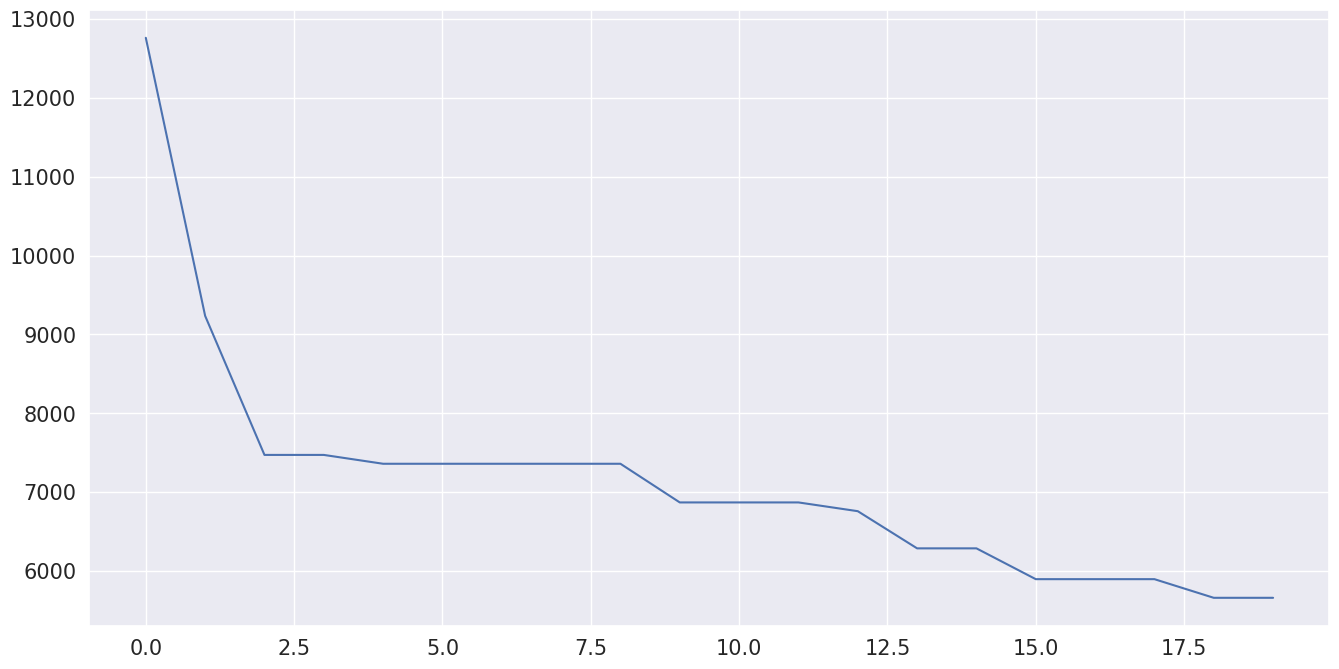

<ipython-input-96-739a2ca5dd5d>:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(self.Customer_CS_Node.cities_coord[1:, 0], self.Customer_CS_Node.cities_coord[1:, 1], s=plot_size*2, cmap='viridis')
<ipython-input-96-739a2ca5dd5d>:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(self.Customer_CS_Node.charging_coord[:, 0], self.Customer_CS_Node.charging_coord[:, 1], s=plot_size*4, cmap='viridis', marker='s')
<ipython-input-96-739a2ca5dd5d>:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(self.Customer_CS_Node.cities_coord[0, 0], self.Customer_CS_Node.cities_coord[0, 1], s=plot_size*4, cmap='viridis')


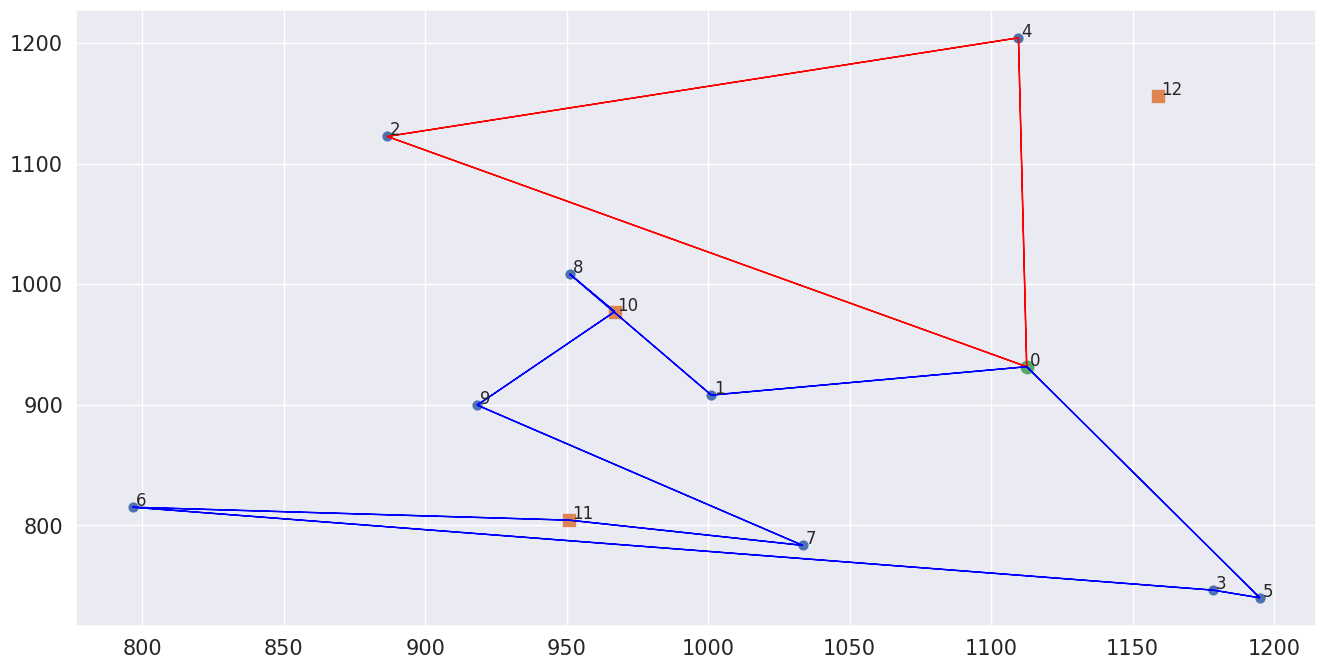

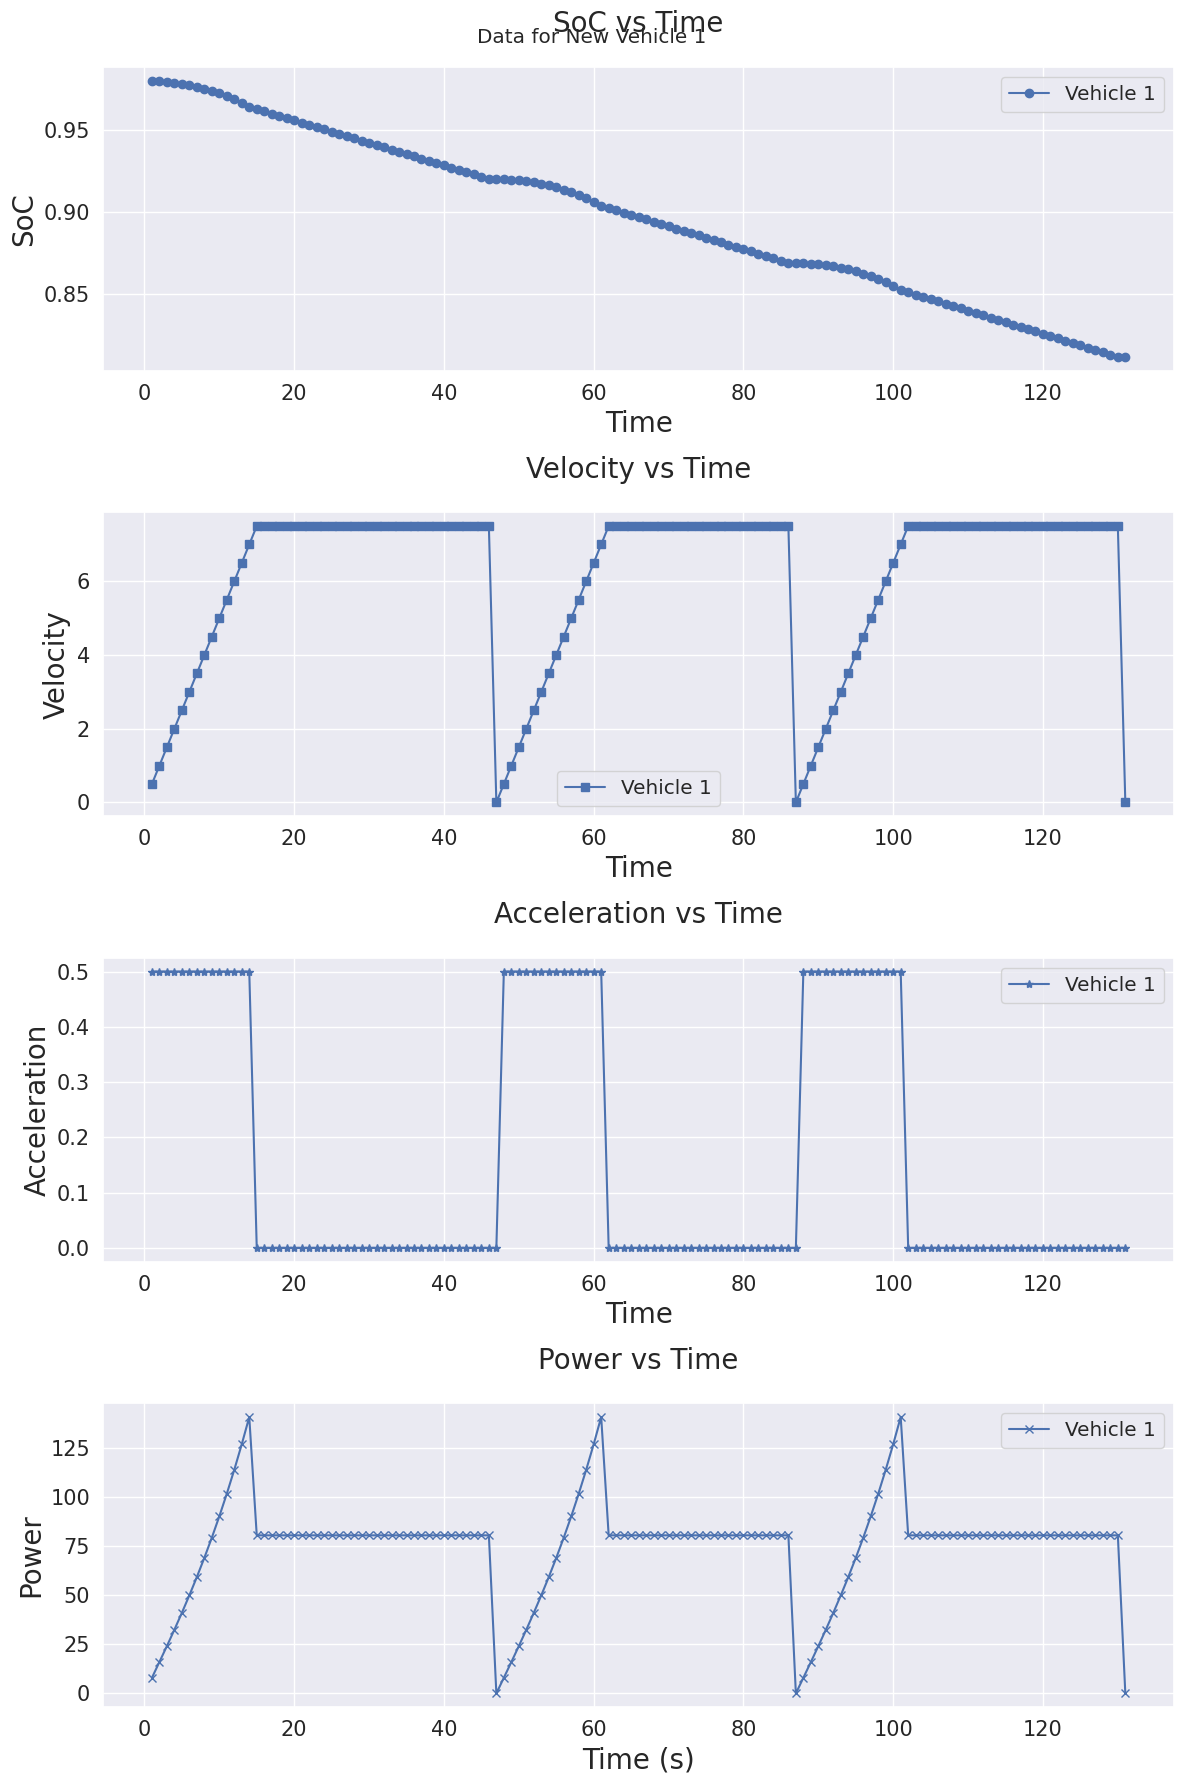

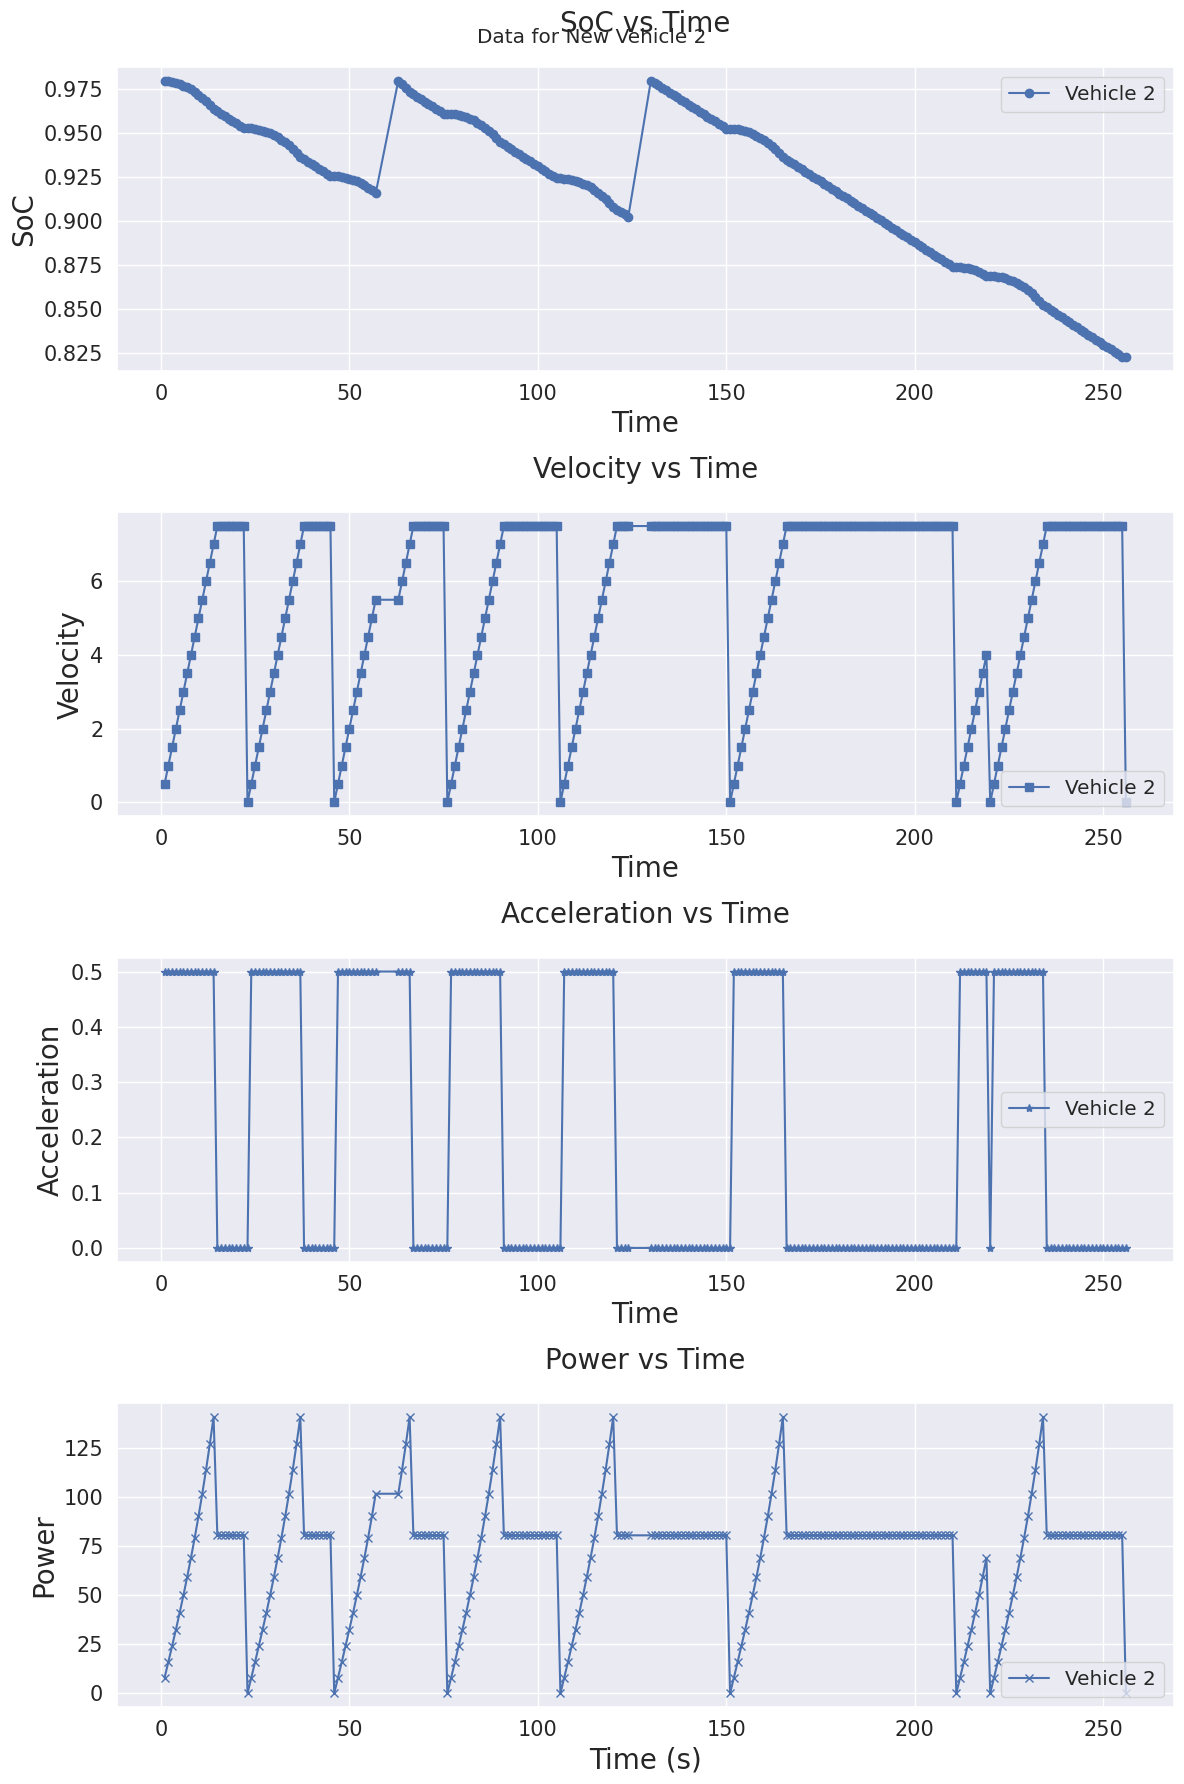

[(0, 0), (206.04, 291.82), (309.69, 379.74), (331.47, 406.58), (253.09, 309.57), (351.01, 426.57), (213.92, 313.28), (316.8, 391.51), (273.42, 367.44), (344.07, 441.94)]


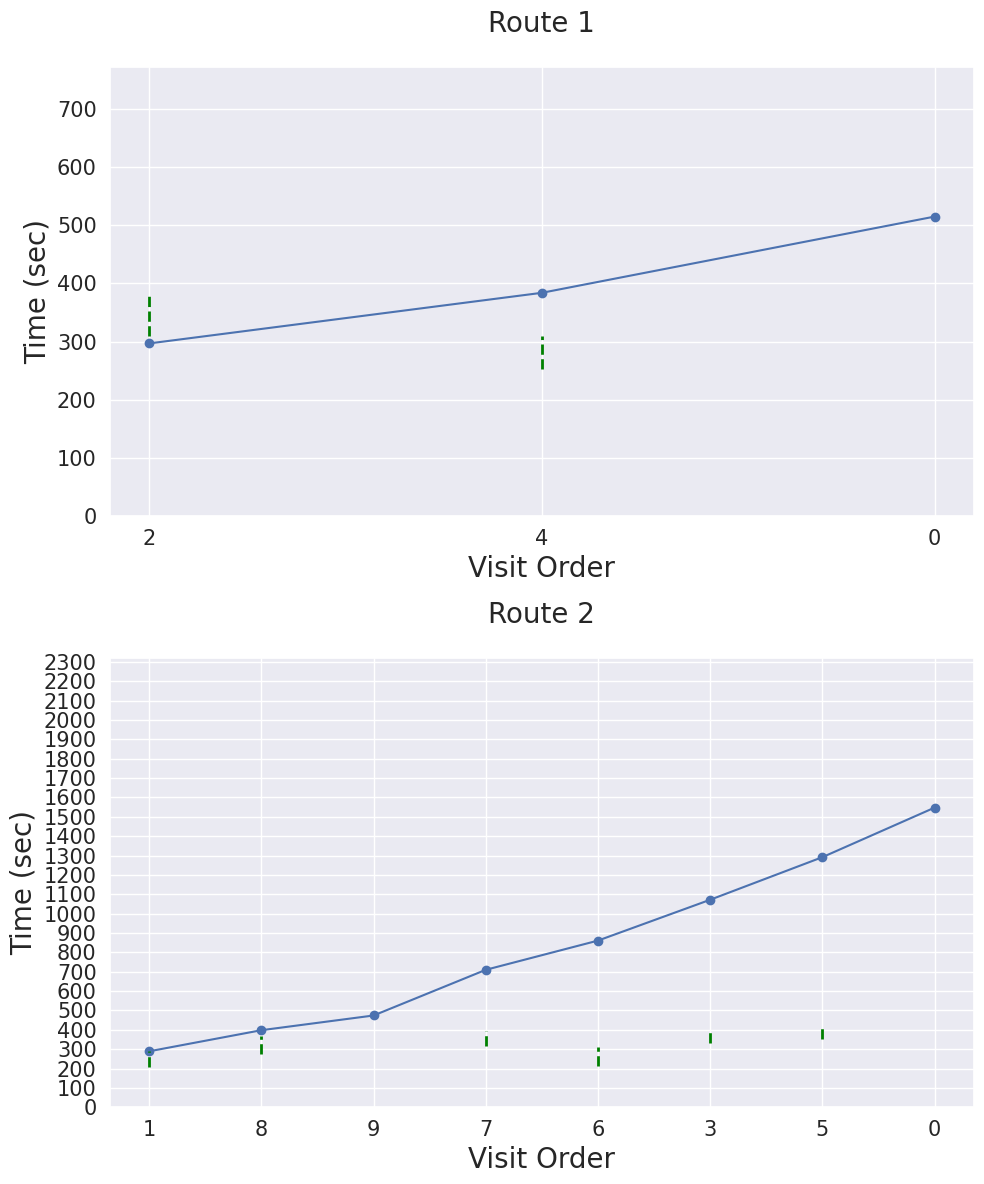

In [ ]:
if __name__ == "__main__":

    ga = GeneticAlgorithm(soc_set=[0.98, 0.98], num_vehicles=2, vehicle_payload=50, DeltaT=1, num_cities=10, num_CS=3, center_box=(1000, 1000),
                          start_time=200, end_time=600, V_max=[7, 7.5, 8, 8.5, 9, 9.5, 10], a_max=[0.5, 0.5, 1, 1.5, 1.5],
                          charging_time=2, Capacity_CS=1, Charging_duration=5, CostBattery=10000, CostEng=0.1, CostTime=1,
                          num_population=100, num_generations=20, prob_crossover=0.8, prob_mutation=0.2)


    best_fitness, best_individual = ga.run_genetic_algorithm()


    plot = PlottingClass(num_cities=10, num_CS=3, center_box=(1000, 1000),
                         start_time=200, end_time=600, Capacity_CS=1, GA=ga, best_individual=best_individual,
                         best_fitness=best_fitness)

    plot.plot_cost()

    plot.plot_routes()

    plot.plot_other_metrics()

    plot.plot_time_window()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')